# Visualization of Household Water Use Data
Created by Amber Jones, December 2020

In [37]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
import matplotlib.patches as patches
from matplotlib import rcParams
from matplotlib import gridspec

### Import Classified/Labeled Event Data

In [38]:
df_events = pd.read_csv('Classified_Events.csv', engine='python', header=0, parse_dates=True, infer_datetime_format=True)

## Daily Flow Plots
This script plots flow diagrams (Sankey plots) for the in/out of water flows on a daily basis. The script imports labeled event data, groups according to labels, divides into daily averages, and classifies as indoor/outdoor. Flow plots are made for overall water use and indoor. Indoor is created separately because of variation in scale.

### Organize data as in/out flows


In [39]:
# Aggregate all events by use
df_flows = df_events.groupby('Label', as_index=False)['Volume(gal)'].sum().sort_values('Volume(gal)', ascending=False)
# Daily averages
df_flows['daily'] = (df_flows['Volume(gal)']/14).astype(int)
# Class indoor/outdoor
df_in_out_flows = pd.DataFrame({'Label': ('Indoor', 'Outdoor', 'Total'),
                                'Daily Volume': (-df_flows['daily'][(df_flows.Label != 'irrigation') & (df_flows.Label != 'hose')].sum(),
                                                 -df_flows['daily'][(df_flows.Label == 'irrigation') | (df_flows.Label == 'hose')].sum(),
                                                 df_flows['daily'].sum()
                                                 )})


### Organize indoor use as in/out flows


In [40]:
df_indoor_flows = df_flows[(df_flows.Label != 'irrigation') & (df_flows.Label != 'hose')]
df_indoor_flows['daily'] = -df_indoor_flows['daily'].astype(int)
df_indoor_flows = df_indoor_flows.append(-df_indoor_flows.sum(numeric_only=True), ignore_index=True)
df_indoor_flows.iloc[4, 0] = 'Indoor'


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Daily Flow Plots
plots 2 subplots: one for overall split between outdoor and indoor, another for indoor uses.


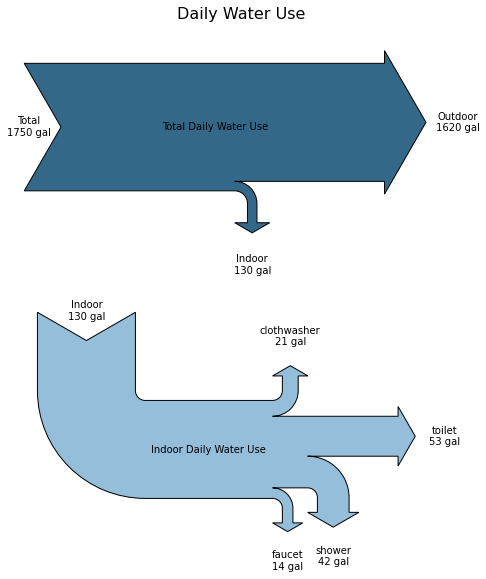

In [41]:
# Overall
# input data
flows = df_in_out_flows['Daily Volume']
labels = df_in_out_flows['Label']
color = '#346888'
# plotting
fig = plt.figure(figsize=(8, 10), facecolor='w')
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = fig.add_subplot(2, 1, 1)
ax.axis('off')
in_out_flows = Sankey(ax=ax, head_angle=120, unit=' gal', scale=1/1751, offset=0.25, margin=0.2, shoulder=0.1,)
in_out_flows.add(flows=flows, labels=labels, orientations=[-1, 0, 0], pathlengths=[0.25, 1, 1.5],
                 trunklength=0.5, facecolor=color, linewidth=1, patchlabel='Total Daily Water Use')
diagrams = in_out_flows.finish()
plt.title('Daily Water Use', fontsize=16)

# Indoor
# input data
flows = df_indoor_flows['daily']
labels = df_indoor_flows['Label']
color = '#94bed9'
# plotting
ax = fig.add_subplot(2, 1, 2)
ax.axis('off')
indoor_flows = Sankey(ax=ax, head_angle=120, unit=' gal', scale=1/130, offset=0.3, margin=0.2, shoulder=0.1,)
indoor_flows.add(flows=flows, labels=labels, orientations=[0, -1, 1, -1, 1], pathlengths=[0.5, 0.25, 0.25, 0.25, 0.9],
                 trunklength=1.5, facecolor=color, linewidth=1, patchlabel='Indoor Daily Water Use')
diagrams = indoor_flows.finish()
plt.show()

In [42]:
# to save
plt.savefig('Images/flowplots.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

## Irrigation Cost Scenarios
This script focuses on outdoor/irrigation/sprinkler watering including several watering/irrigation scenarios. Hose use is also an outdoor use, but is disregarded for this analysis. The script imports labeled event data, groups by label, determines average daily and monthly volumes.

Scenario 1: Reduce irrigation rate. Uses 1 inch/week recommendation.

Scenario 2: Reduce irrigated area. Uses half of currently irrigated area.

Scenario 3: Reduce both rate and area.

All of these are compared to the current. Pricing for each scenario was also determined based on Providence City tiered rates.

### Organize data

In [43]:
# Group data by label
df = df_events.groupby('Label', as_index=False)['Volume(gal)'].sum()
df['Volume(gal)'] = df['Volume(gal)'].astype(int)
# Reorder rows
df = df.reindex([3, 2, 5, 4, 0, 1])
# Add columns for daily and monthly
df['daily'] = (df['Volume(gal)']/14).astype(int)
df['monthly'] = df['daily'] * 30



### Irrigation scenarios

In [44]:
# Reduce irrigation rate
#####################
# Recommended irrigation for turfgrass: 1 inch water = 27154 gallons/acre
# (see https://www.lowes.com/n/how-to/watering-tips)
lot_size = 0.28
lot_fraction = 2/3  # removing house and paved
one_inch = 27154  # gallons/acre per week
reduce_watering = one_inch * lot_size * lot_fraction * 30/7
# 27154 * 0.28 * 2/3 * (30 days/month) / (7 days/week) = 21723 gallons/month
# Comaparing to the current practice
current = df['monthly'][df['Label'] == 'irrigation'].sum()  # monthly water use under current scenario
current_inches = current*7/30*1/lot_fraction*1/lot_size*1/one_inch  # weekly watering depth under current scenario
# 47340 * 7/30 * 3/2 * 1/0.28 *1/27154 = 2.18 inches/week

# Reduce irrigated area
#####################
lot_reduce = 0.5
reduce_lawn = current * lot_reduce
reduce_both = one_inch * lot_size * lot_fraction * lot_reduce * 30/7
# 27154 gallons/acre 0.28*2/3*0.5 acres = 2534.5 gal is 1 inch of water
# 27154 * 0.28 * 2/3 * 30/7 * 0.5 = 10862 gallons/month

# Define datasets
#####################
Labels = ['Sprinklers', 'Indoor']
Scenario = ['Current Watering', 'Reduce Lawn', 'Reduce Watering', 'Reduce Both']
indoor = df['monthly'][df['Label'] != 'irrigation'].sum()
Indoor = [indoor, indoor, indoor, indoor]
Sprinklers = [current, reduce_lawn, reduce_watering, reduce_both]

### Pricing
Providence City water rate tiers:

$23.25 for 10,000 gallons of water.

$0.75 per 1,000 gallons from 10,001 to 50,000 gallons.

$1.50 per 1,000 gallons over 50,000 gallons.

In [45]:
tier1 = 10000
tier2 = 50000
flat_rate = 23.25
rate_tier1 = 0.75
rate_tier2 = 1.5

# Create dataframe with pricing information
pricing = pd.DataFrame({'Scenario': Scenario, 'Indoor': Indoor, 'Sprinklers': Sprinklers})
pricing['Total'] = pricing['Indoor'] + pricing['Sprinklers']
pricing['FirstTier'] = np.where(pricing['Total'] >= tier2, tier2-tier1, pricing['Total']-tier1)
pricing['SecondTier'] = np.where(pricing['Total'] >= tier2, pricing['Total']-tier2, 0)
pricing['FirstTierCost'] = pricing['FirstTier']*rate_tier1/1000
pricing['SecondTierCost'] = pricing['SecondTier']*rate_tier2/1000
pricing['TotalCost'] = pricing['FirstTierCost'] + pricing['SecondTierCost'] + flat_rate


### Plotting

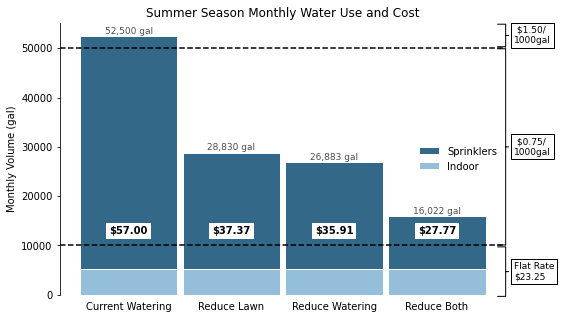

In [46]:
# Bar chart
#####################
# Creates a stacked bar chart with indoor use remaining constant and sprinkler use varying for each scenario.
# Includes annotations for each pricing tier.

fig1 = plt.figure(figsize=(8, 5), facecolor='w')
ax = fig1.add_subplot(1, 1, 1)

outdoor_color = '#346888'
indoor_color = '#94bed9'
width = 0.95

# Bars
p1 = ax.bar(Scenario, Sprinklers, bottom=Indoor, color=outdoor_color, width=width, edgecolor='w')
p2 = ax.bar(Scenario, Indoor, bottom=0, color=indoor_color, width=width, edgecolor='w')

# Lines and labels
p3 = ax.axhline(y=tier1, linewidth=1.5, linestyle='--', color='k')
# plt.text(x=4.5, y=10500, s='Flat Rate Tier', fontweight='bold', color='k')
p4 = ax.axhline(y=tier2, linewidth=1.5, linestyle='--', color='k')
# plt.text(x=4.5, y=50500, s='Irrigation Tier', fontweight='bold', color='gray')

# Cost and volume annotations
for i, rows in pricing.iterrows():
    ax.annotate('{:,.0f}'.format(rows['Total']) + ' gal', xy=(i, rows['Total']+1000),
                rotation=0, color='k', ha='center', va='center', alpha=0.7, fontsize=9)
    ax.annotate('${:,.2f}'.format(rows['TotalCost']), xy=(i, 13000),
                rotation=0, color='k', ha='center', va='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='square', fc='white', linewidth=0))

# Brackets for Rate Ranges
x1 = 3.65
x2 = 3.75
ax.annotate('Flat Rate\n$23.25', xy=(x1, 4700), xytext=(x2, 4700), annotation_clip=False, rotation=0,
            fontsize=9, ha='left', va='center',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=2.75, lengthB=0.9', lw=1))
ax.annotate(' $0.75/\n1000gal', xy=(x1, 30000), xytext=(x2, 30000), annotation_clip=False, rotation=0,
            fontsize=9, ha='left', va='center',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=10.9, lengthB=0.9', lw=1))
ax.annotate(' $1.50/\n1000gal', xy=(x1, 52600), xytext=(x2, 52600), annotation_clip=False, rotation=0,
            fontsize=9, ha='left', va='center',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=1.25, lengthB=0.9', lw=1))

# Extras
ax.legend((p1, p2), Labels, loc='center right', ncol=1, frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
plt.ylabel('Monthly Volume (gal)')
plt.title('Summer Season Monthly Water Use and Cost')
plt.show()

In [47]:
# to save
plt.savefig('Images/outdoor_scenarios.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

Text(97, 55, 'Recommended watering')

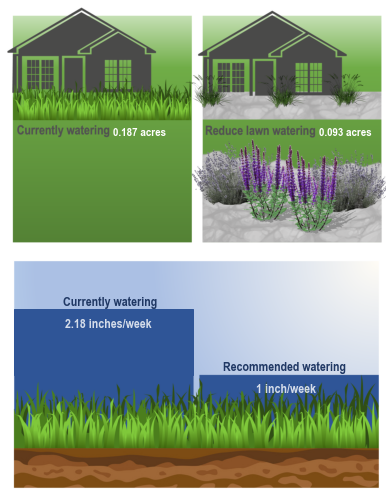

In [48]:
# Illustrations
#####################
# Creates an illustration of a reduced lot size with labels for irrigated area
fig2 = plt.figure(figsize=(7, 9))
fig2.subplots_adjust(hspace=0, wspace=0)
ax = fig2.add_subplot(2, 1, 1)
# import background
img = plt.imread('Images/house.png')
ax.imshow(img, extent=[0, 170, 0, 110])
ax.axis('off')
# add text
plt.text(x=47.5, y=51.15, s='{:,.3f}'.format(lot_size * lot_fraction) + ' acres',
         fontweight='bold', color='w', fontname='Arial Narrow', va='bottom', fontsize=12)
plt.text(x=140, y=51.15, s='{:,.3f}'.format(lot_size * lot_fraction * lot_reduce) + ' acres',
         fontweight='bold', color='w', fontname='Arial Narrow', va='bottom', fontsize=12)

# Creates an illustration with grass to compare weekly watering rates
ax = fig2.add_subplot(2, 1, 2)
# import background
img = plt.imread("Images/grass.png")
ax.imshow(img, extent=[0, 170, 0, 110])
ax.axis('off')
# Create a Rectangle patch and add to axes
rect = patches.Rectangle((3.28, 54.5), 80.15, (25*(current_inches-1)), linewidth=1, edgecolor='#2F5597', facecolor='#2F5597')
ax.add_patch(rect)
# add text
plt.text(x=26, y=45+(25*(current_inches-1)), s='{:,.2f}'.format(current_inches) + ' inches/week',
         fontweight='bold', color='w', fontname='Arial Narrow', va='bottom', fontsize=13, alpha=0.8)
plt.text(x=25, y=55+(25*(current_inches-1)), s='Currently watering',
         fontweight='bold', color='#203864', fontname='Arial Narrow', va='bottom', fontsize=13)
plt.text(x=112, y=45, s='1 inch/week',
         fontweight='bold', color='w', fontname='Arial Narrow', va='bottom', fontsize=13, alpha=0.8)
plt.text(x=97, y=55, s='Recommended watering',
         fontweight='bold', color='#203864', fontname='Arial Narrow', va='bottom', fontsize=13)

In [49]:
# to save
plt.savefig('Images/outdoor_illustration.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

## Indoor Water Use
This script focuses on indoor water use including several shower scenarios. Hose use is disregarded for this analysis. The script imports labeled event data, groups by label, subsets into indoor use.The duration range of each use is compared in one plot. Another plot examines the hourly volume for each use.There is little variation in uses other than shower, so shower durations are examined at each hour. Three scenarios are considered for reducing shower volumes:

Scenario 1: Use ultra low flow showerheads (1.26 gpm).

Scenario 2: Keep all showers less than 10 minutes.

Scenario 3: Reduce both flow rate and duration.

All of these are compared to the current.


### Variability in Uses


In [50]:
# Organize Data
#####################
# get indoor data, aggregate and label
df_indoor_events = df_events[(df_events.Label != 'irrigation') & (df_events.Label != 'hose')]
df_indoor_grouped = df_indoor_events.groupby(['Label'], as_index=False).agg({'Volume(gal)': np.sum, 'Duration(min)': ['mean', 'min', 'max']})
df_indoor_grouped.columns = ['Label', 'Volume_tot', 'Duration_mean', 'Duration_min', 'Duration_max']
df_indoor_grouped = df_indoor_grouped.sort_values('Volume_tot')
df_indoor_grouped['Label'] = ['Faucet', 'Clothes\nWasher', 'Shower', 'Toilet']

Text(0.5, 1.0, 'Variation in Duration for Indoor Uses')

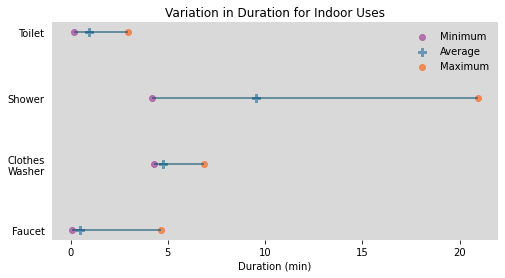

In [51]:
# Plotting duration ranges for each use
#####################
# this could also be done for volume ranges.
# this is similar to violin or boxplot but removes the frequency element for simplicity.
fig1 = plt.figure(figsize=(8, 4), facecolor='w')
ax = fig1.add_subplot(1, 1, 1)
colors = ['#004c6d', '#6996b3', '#F5793A', '#A95AA1']
# plot horizontal lines and points for min, max, mean
ax.hlines(y=df_indoor_grouped['Label'], xmin=df_indoor_grouped['Duration_min'], xmax=df_indoor_grouped['Duration_max'], color=colors[0], alpha=0.7)
ax.scatter(df_indoor_grouped['Duration_min'], df_indoor_grouped['Label'], color=colors[3], alpha=0.8, label='Minimum')
ax.scatter(df_indoor_grouped['Duration_mean'], df_indoor_grouped['Label'], marker='P', s=70, color=colors[1], label='Average')
ax.scatter(df_indoor_grouped['Duration_max'], df_indoor_grouped['Label'], color=colors[2], alpha=0.8, label='Maximum')
# additional styling
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(frameon=False)
ax.set_facecolor(plt.cm.tab20c(19))
ax.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
plt.xlabel('Duration (min)')
plt.title('Variation in Duration for Indoor Uses')

In [52]:
# to save
plt.savefig('Images/indoor_durations.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

### Hourly Aggregation

In [53]:
# Organize Data
#####################
# Add hour of event
df_hourly = df_events[['Volume(gal)', 'Duration(min)', 'Label']].copy()
df_hourly['Hour'] = pd.to_datetime(df_events['StartTime']).dt.hour
# Group data into total volume and mean/min/max duration for each hour/label
df_grouped = df_hourly.groupby(['Label', 'Hour'], as_index=False).agg({'Volume(gal)': np.sum, 'Duration(min)': ['mean','min','max']})
df_grouped.columns = ['Label', 'Hour', 'Volume_tot', 'Duration_mean', 'Duration_min', 'Duration_max']
# Pivot table based on hourly volume
df_hr_vol = pd.pivot_table(df_grouped, values='Volume_tot', index=['Hour'], columns=['Label'], fill_value=0)
df_hr_vol = df_hr_vol[['irrigation', 'hose', 'shower', 'toilet', 'clothwasher', 'faucet']]
# Subset indoor use
df_hr_vol = df_hr_vol.drop(columns=['irrigation', 'hose'], index=[0, 3, 4, 5, 6])
df_hr_vol = df_hr_vol.rename(columns={'shower': 'Shower', 'toilet':'Toilet', 'clothwasher': 'Clothes Washer', 'faucet': 'Faucet'})

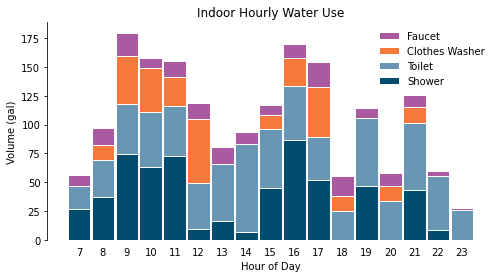

In [54]:
# Plot Hourly Indoor Uses
#####################
fig2 = plt.figure(figsize=(8, 4), facecolor='w')
ax = fig2.add_subplot(1, 1, 1)
labels = list(df_hr_vol.columns)
colors = ['#004c6d', '#6996b3', '#F5793A', '#A95AA1']
N = len(df_hr_vol)
bottom = np.zeros(N)
width = 0.95
# create bars
for elem, color in zip(labels, colors):
    ax.bar(df_hr_vol.index, df_hr_vol[elem], bottom=bottom, color=color, width=width, edgecolor='w', label=elem)
    bottom += df_hr_vol[elem]
# reorder legend labels to match stacked bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False)
# additional styling
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
plt.ylabel('Volume (gal)')
plt.xticks(df_hr_vol.index)
plt.xlabel('Hour of Day')
plt.title('Indoor Hourly Water Use')
plt.show()

In [55]:
# to save
plt.savefig('Images/indoor_volumes.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Hourly Range of Shower Durations')

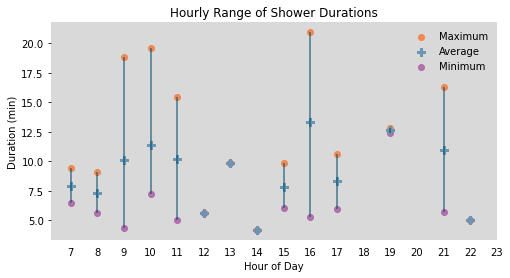

In [56]:
# Plot Hourly Shower Durations
#####################
# this could also be done for volume ranges.
# this is similar to violin or boxplot but removes the frequency element for simplicity.
df_hr_shower = df_grouped[df_grouped['Label'] == 'shower']

fig3 = plt.figure(figsize=(8, 4), facecolor='w')
ax = fig3.add_subplot(1, 1, 1)
colors = ['#004c6d', '#6996b3', '#F5793A', '#A95AA1']
ax.vlines(x=df_hr_shower['Hour'], ymin=df_hr_shower['Duration_min'], ymax=df_hr_shower['Duration_max'], color=colors[0], alpha=0.7)
ax.scatter(df_hr_shower['Hour'], df_hr_shower['Duration_max'], color=colors[2], alpha=0.8, label='Maximum')
ax.scatter(df_hr_shower['Hour'], df_hr_shower['Duration_mean'],  marker='P', s=70, color=colors[1], label='Average')
ax.scatter(df_hr_shower['Hour'], df_hr_shower['Duration_min'], color=colors[3], alpha=0.8, label='Minimum')
ax.scatter(df_hr_shower['Hour'], df_hr_shower['Duration_mean'],  marker='P', s=70, color=colors[1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(frameon=False)
ax.set_facecolor(plt.cm.tab20c(19))
ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
plt.ylabel('Duration (min)')
plt.xticks(df_hr_vol.index)
plt.xlabel('Hour of Day')
plt.title('Hourly Range of Shower Durations')

In [57]:
# to save
plt.savefig('Images/shower_durations.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

### Shower Scenarios

In [58]:
# Subset data for showers only
df_shower = df_events[df_events['Label'] =='shower']

# Current Scenario
#####################
current_daily_vol = df_shower['Volume(gal)'].sum()/14
# 42 gal/day
current_daily_dur = df_shower['Duration(min)'].sum()/14
# 22.4 minutes/day
current_gpm = df_shower['Volume(gal)'].sum()/df_shower['Duration(min)'].sum()
# 1.88 gpm

# Reduce Shower Duration
#####################
max_duration = 10  # set maximum shower duration (min)
df_shower['ShortShowerDuration'] = np.where(df_shower['Duration(min)'] >= max_duration, max_duration, df_shower['Duration(min)'])
short_dur = df_shower['ShortShowerDuration'].sum()/14
# 18.9 minutes/day
short_dur_vol = short_dur * current_gpm
# 35.1 gal/day
short_dur_save = current_daily_vol - short_dur_vol
# saving 7 gal/day

# Ultra Low Flow Shower Head
#####################
low_flow = 1.26  # set low flow shower rate (gpm)
low_flow_vol = current_daily_dur * low_flow
# 33.6 gal/day
low_flow_save = current_daily_vol - low_flow_vol
# saving 8.5 gal/day

# Reduce Both Flow and Duration
#####################
both_vol = short_dur * low_flow
# 28 gal/day
both_save = current_daily_vol - both_vol
# saving 14 gal/day

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Plotting

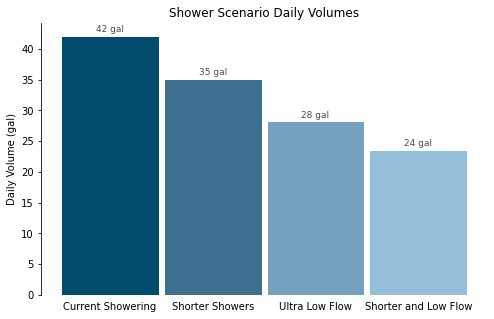

<Figure size 432x288 with 0 Axes>

In [59]:
# inputs
Scenario = ['Current Showering', 'Shorter Showers', 'Ultra Low Flow', 'Shorter and Low Flow']
Volume = [current_daily_vol, short_dur_vol, low_flow_vol, both_vol]

# Bar Chart
#####################
fig4 = plt.figure(figsize=(8, 5), facecolor='w')
ax = fig4.add_subplot(1, 1, 1)
colors = ['#004c6d', '#3d708f', '#75a1be', '#94bed9']
width = 0.95
# Bars
p1 = plt.bar(Scenario, Volume, bottom=0, color=colors, width=width, edgecolor='w')
# Volume annotations
for i in range(len(Volume)):
    plt.annotate('{:.0f}'.format(Volume[i]) + ' gal', xy=(i, Volume[i] + 1), rotation=0, color='k', ha='center', va='center', alpha=0.7, fontsize=9)
# Styling
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
plt.ylabel('Daily Volume (gal)')
plt.title('Shower Scenario Daily Volumes')
plt.show()

# to save
plt.savefig('Images/shower_scenarios.png', bbox_inches='tight')

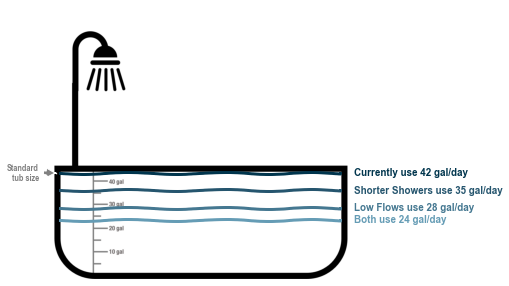

In [60]:
# Bathtub Plot
#####################
Labels = ['Currently use ' + str(round(current_daily_vol)) + ' gal/day',
          'Shorter Showers use ' + str(round(short_dur_vol)) +' gal/day',
          'Low Flows use ' + str(round(low_flow_vol)) +' gal/day',
          'Both use ' + str(round(both_vol)) +' gal/day']
colors = ['#00354d', '#25556e', '#457891', '#659cb5']
# read in bathtub image
img = plt.imread('Images/TubEmpty.png')
fig5 = plt.figure(figsize=(8, 5), facecolor='w')
ax = fig5.add_subplot(1, 1, 1)
ax.axis('off')
ax.imshow(img, extent=[0, 140, 0, 108])
# to get wavy lines
rcParams['path.sketch'] = (1, 100, 2)
# lines and labels
for i in range(len(Volume)):
    ax.plot(np.linspace(3.5, 114.5, 1000), [Volume[i]] * 1000, color=colors[i], linewidth=3)
    plt.text(x=120, y=Volume[i], s=Labels[i],
             fontweight='bold', color=colors[i], fontname='Arial Narrow', va='center',fontsize=12)
# standard tub size annotation with arrow
ax.annotate('Standard\ntub size', xy=(3, 42), xytext=(-5, 42), annotation_clip=False, rotation=0,
            fontsize=9, ha='right', va='center', fontname='Arial Narrow', color='gray', fontweight='bold',
            arrowprops=dict(arrowstyle='simple', mutation_scale=22, facecolor='gray', edgecolor='w'),
            horizontalalignment='right', verticalalignment='top',
            )
# for simple straight lines:
# ax.hlines(y=Volume, xmin=3, xmax=115, linewidth=1.5, linestyle='--', color=colors)
# reset to remove the wavy line setting
rcParams['path.sketch'] = (0, 0, 0)

In [61]:
# to save
plt.savefig('Images/tub_illustration.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

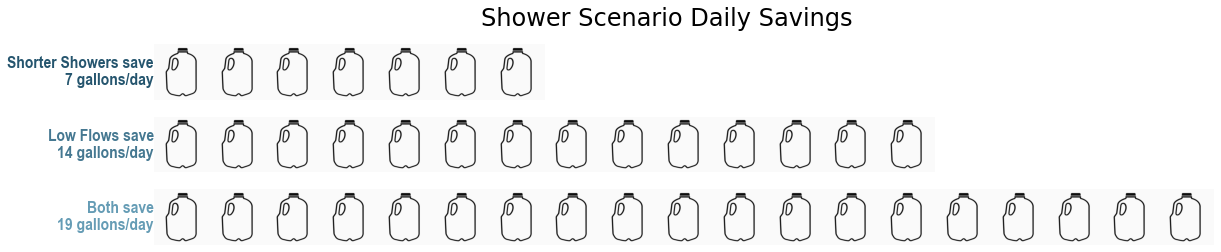

In [62]:
# Savings Plot
#####################
# plots milkjug images to indicate savings in gallons/day

# inputs
savings = [round(current_daily_vol - short_dur_vol),
           round(current_daily_vol - low_flow_vol),
           round(current_daily_vol - both_vol)]
text = ['Shorter Showers save\n' + str(savings[0]) +' gallons/day',
          'Low Flows save\n' + str(savings[1]) +' gallons/day',
          'Both save\n' + str(savings[2]) +' gallons/day']
colors = ['#25556e', '#457891', '#659cb5']
ncol = max(savings)
nrow = len(savings)

# create plot
fig6, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol, nrow+1), facecolor='w')
# reduce spacing
fig6.subplots_adjust(hspace=0.00, wspace=0.00)
gs = gridspec.GridSpec(nrow, ncol,
         wspace=0.0, hspace=0.0,
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
         left=0.5/(ncol+1), right=1-0.5/(ncol+1))
# create subplots. each subplot corresponding to savings receives a milkjug image.
for i, axi in enumerate(ax.flat):
    axi.axis('off')
    # i runs from 0 to (nrows * ncols-1)
    # axi is equivalent with ax[rowid][colid]
    if (i < savings[0]) or (ncol <= i < (ncol + savings[1])) or (ncol * 2 <= i < (ncol * 2 + savings[2])):
        img = plt.imread('Images/milkjug.png')
        axi.imshow(img, alpha=0.95, extent=[0, 550, 0, 550])
# add text
ax[0][0].annotate(text[0], xy=(0, 275), xytext=(0, 275), annotation_clip=False, rotation=0,
            fontsize=17, ha='right', va='center', fontname='Arial Narrow', color=colors[0], fontweight='bold',
            horizontalalignment='right', verticalalignment='top')
ax[1][0].annotate(text[1], xy=(0, 275), xytext=(0, 275), annotation_clip=False, rotation=0,
            fontsize=17, ha='right', va='center', fontname='Arial Narrow', color=colors[1], fontweight='bold',
            horizontalalignment='right', verticalalignment='top')
ax[2][0].annotate(text[2], xy=(0, 275), xytext=(0, 275), annotation_clip=False, rotation=0,
            fontsize=17, ha='right', va='center', fontname='Arial Narrow', color=colors[2], fontweight='bold',
            horizontalalignment='right', verticalalignment='top')
fig6.suptitle('Shower Scenario Daily Savings', fontsize=24)
plt.show()

In [63]:
# to save
plt.savefig('Images/milkjug_illustration.png', bbox_inches='tight')


<Figure size 432x288 with 0 Axes>